In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [89]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv', index_col='date')

In [90]:
imputer = SimpleImputer(missing_values=np.nan) # Handling missing values
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)


In [91]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [92]:
# Dataset splitting
SPLIT = 0.9
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [93]:
n_forecast = 5

In [94]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='tanh'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 30)                3420      
                                                                 
 dropout_6 (Dropout)         (None, 30)                0         
                                                                 
 dense_6 (Dense)             (None, 5)                 155       
                                                                 
Total params: 3575 (13.96 KB)
Trainable params: 3575 (13.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
history = model_gru.fit(X_train, y_train, epochs=20, batch_size=12)

Epoch 1/20
143/143 [==============================] - 8s 10ms/step - loss: 0.0236 - MAE: 0.1149
Epoch 2/20
143/143 [==============================] - 2s 11ms/step - loss: 0.0148 - MAE: 0.0891
Epoch 3/20
143/143 [==============================] - 2s 11ms/step - loss: 0.0120 - MAE: 0.0777
Epoch 4/20
143/143 [==============================] - 2s 11ms/step - loss: 0.0110 - MAE: 0.0725
Epoch 5/20
143/143 [==============================] - 2s 11ms/step - loss: 0.0105 - MAE: 0.0690
Epoch 6/20
143/143 [==============================] - 2s 14ms/step - loss: 0.0097 - MAE: 0.0653
Epoch 7/20
143/143 [==============================] - 2s 16ms/step - loss: 0.0095 - MAE: 0.0643
Epoch 8/20
143/143 [==============================] - 2s 17ms/step - loss: 0.0093 - MAE: 0.0619
Epoch 9/20
143/143 [==============================] - 2s 12ms/step - loss: 0.0091 - MAE: 0.0607
Epoch 10/20
143/143 [==============================] - 2s 11ms/step - loss: 0.0089 - MAE: 0.0604
Epoch 11/20
143/143 [==================

In [96]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


6/6 [==============================] - 1s 5ms/step


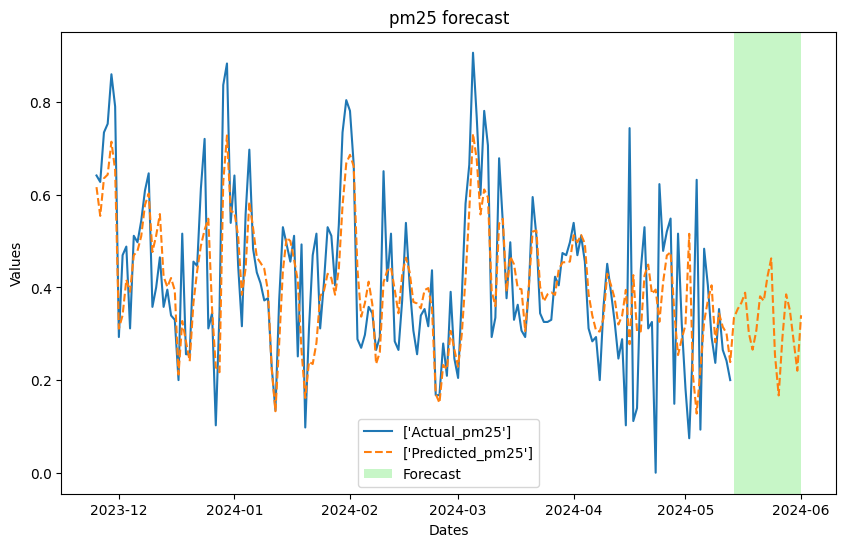

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [98]:
predicted_values

array([[0.6167178 , 0.6210537 , 0.61759615, 0.62761486, 0.62519646],
       [0.5546554 , 0.561099  , 0.5597109 , 0.5681631 , 0.56644934],
       [0.6358015 , 0.6411423 , 0.6396275 , 0.64480805, 0.64413065],
       [0.6436945 , 0.6477401 , 0.6466756 , 0.6527231 , 0.6546432 ],
       [0.7148572 , 0.7186988 , 0.71592915, 0.7220157 , 0.7227647 ],
       [0.6530288 , 0.6589037 , 0.6544275 , 0.663515  , 0.66790134],
       [0.3110687 , 0.32042545, 0.31075794, 0.33456475, 0.32967696],
       [0.3402091 , 0.3410661 , 0.3450082 , 0.358333  , 0.3469489 ],
       [0.41699028, 0.4143822 , 0.420811  , 0.43069342, 0.42167   ],
       [0.39064288, 0.38572294, 0.3920817 , 0.40064117, 0.39489293],
       [0.46953997, 0.46470648, 0.4753161 , 0.47469065, 0.4728909 ],
       [0.47928095, 0.47790098, 0.4845716 , 0.48513377, 0.4852931 ],
       [0.5109748 , 0.51169276, 0.5129207 , 0.5135532 , 0.5143903 ],
       [0.57823455, 0.58016795, 0.5796997 , 0.5806855 , 0.58063114],
       [0.6029296 , 0.60683686, 0.

In [99]:
predicted_values[:1].size

5

In [100]:
predicted_values_90 = predicted_values[:18]

In [101]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[134.59433  135.52655  134.78317  136.9372   136.41724 ]
 [121.2509   122.636284 122.337845 124.15507  123.786606]
 [138.69733  139.8456   139.51991  140.63373  140.48808 ]
 [140.39432  141.26413  141.03525  142.33546  142.74828 ]
 [155.6943   156.52023  155.92476  157.23337  157.39441 ]
 [142.40118  143.66429  142.70192  144.65572  145.59879 ]
 [ 68.87977   70.89147   68.81296   73.93142   72.88055 ]
 [ 75.14495   75.32921   76.17676   79.04159   76.59401 ]
 [ 91.65291   91.09217   92.474365  94.59908   92.65905 ]
 [ 85.98822   84.93043   86.29757   88.13785   86.90198 ]
 [102.951096 101.91189  104.19296  104.05849  103.67155 ]
 [105.0454   104.74871  106.18289  106.30376  106.33801 ]
 [111.85959  112.01394  112.27795  112.41394  112.59391 ]
 [126.32043  126.73611  126.63543  126.84738  126.83569 ]
 [131.62987  132.46992  132.21135  131.79527  132.88004 ]
 [104.514656 105.79222  105.43251  105.485985 106.95567 ]
 [112.05851  112.82154  113.413414 112.79094  113.44657 ]
 [122.095184 1

In [102]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

In [103]:
predicted_values_90.size

90

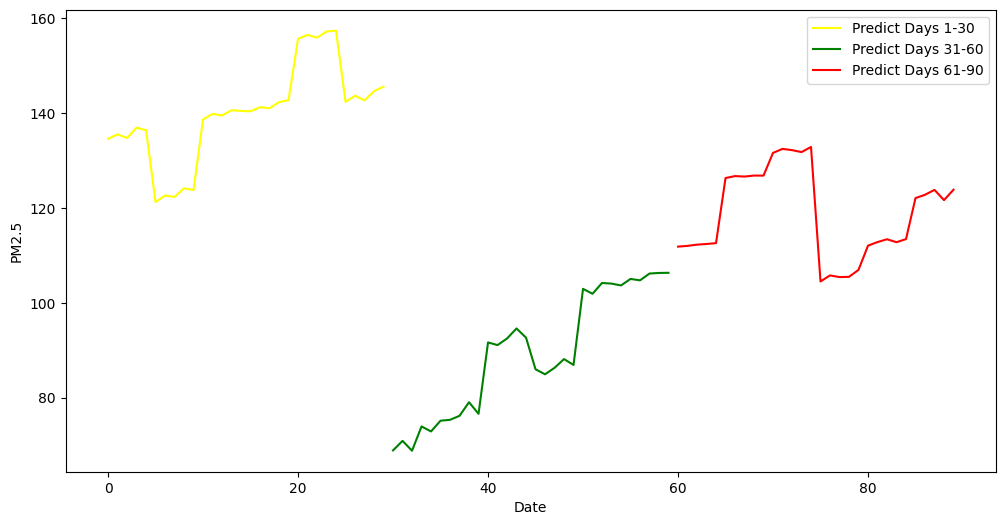

In [104]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


Shape of y_test: (190, 1)
Shape of predicted_values_all: (190, 5)
RMSE: 92.14104764199784
MAE: 88.28249052474956
MAPE: 2071084227216808.5
